# 타이타닉 데이터를 활용한 탑승자의 생사여부 예측

In [13]:
train_df <- read.csv("../../R_class/Data/Titanic_train.csv", fileEncoding = "euc-kr")

In [1]:
# 인공신경망 , 로지스틱 회긔분석
library(nnet)
# 의사결정나무
library(party)
# 랜덤포레스트
library(randomForest)
# SVM
library(e1071)
# sampling
library(caret)

Loading required package: grid
Loading required package: mvtnorm
Loading required package: modeltools
Loading required package: stats4
Loading required package: strucchange
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: sandwich
randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.
Loading required package: lattice
Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: ‘ggplot2’

The following object is masked from ‘package:randomForest’:

    margin



In [70]:
library(dplyr)


Attaching package: ‘dplyr’

The following object is masked from ‘package:randomForest’:

    combine

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [3]:
head(train_df)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,,S
6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,,Q


### 컬럼 내용 확인
- Survived : 생존 여부, 0 = 사망, 1 = 생존
- pclass : 티켓등급 1=1st, 2=2nd, 3=3rd
- Sibsp : 함께 탑승한 형제, 자매, 배우자의 수
- Parch : 함께 탑승한 부모, 자식의 수
- Fare : 운임
- Cabin : 객실번호
- Embarked : 탑승항구, C = Chersbourg, Q = Queenstown, S = Southampton

In [4]:
# NA 확인
colSums(is.na(train_df))

PassengerId    Survived      Pclass        Name         Sex         Age 
          0           0           0           0           0         177 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
          0           0           0           0           0           0

In [5]:
# Age 컬럼 분석가부 확인 ( NA가 20%가 넘어가면 분석이 힘들어진다.)
177/891

[1] 0.1986532

In [11]:
train_df <- subset(train_df,!is.na(train_df$Age))

In [14]:
### Survived의 Target column 적합 여부 확인

# 생존자수
nrow(subset(train_df,Survived == 1))
# 사망자수
nrow(subset(train_df,Survived == 0))
# 비율
nrow(subset(train_df,Survived == 1)) / nrow(train_df)

[1] 342

[1] 549

[1] 0.3838384

taget col(6:4) 가 안돼서 애매하나 시도...

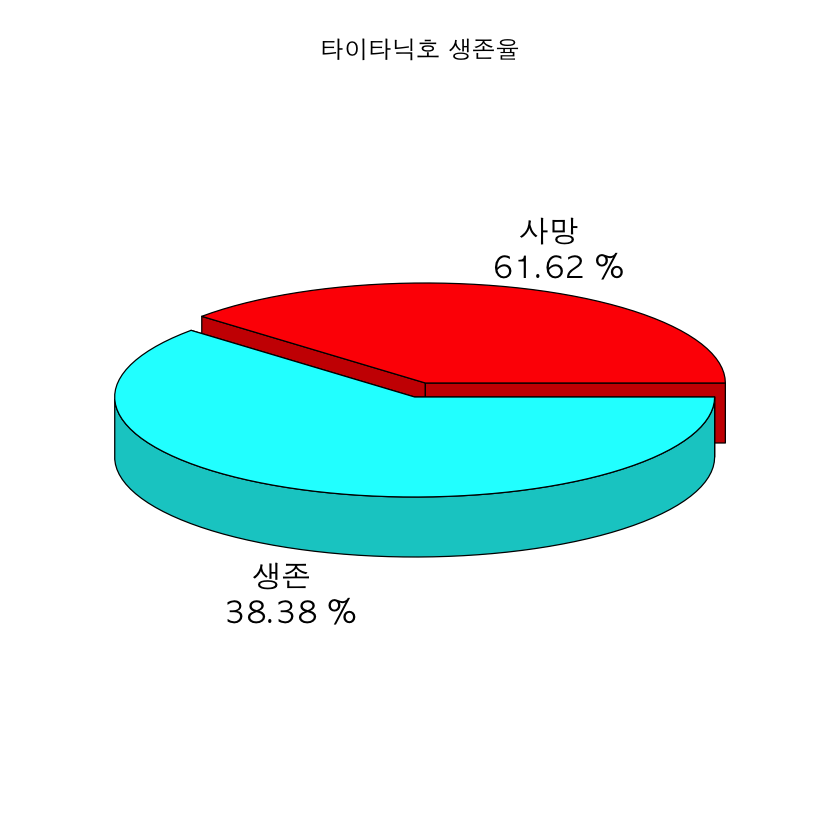

In [9]:
library(plotrix)
# for mac
options(warn = -1)
par(family = "AppleGothic")
a <- c(nrow(subset(train_df,Survived == 1)),nrow(subset(train_df,Survived == 0)))
ratio <- c(nrow(subset(train_df,Survived == 0)) / nrow(train_df) * 100,nrow(subset(train_df,Survived == 1)) / nrow(train_df) * 100)
week <- c("사망","생존")
label <- paste(week,"\n",round(ratio,2),"%")

pie3D(a,
    main = "타이타닉호 생존율",
    labels = label,
    explode = 0.05
    
   )

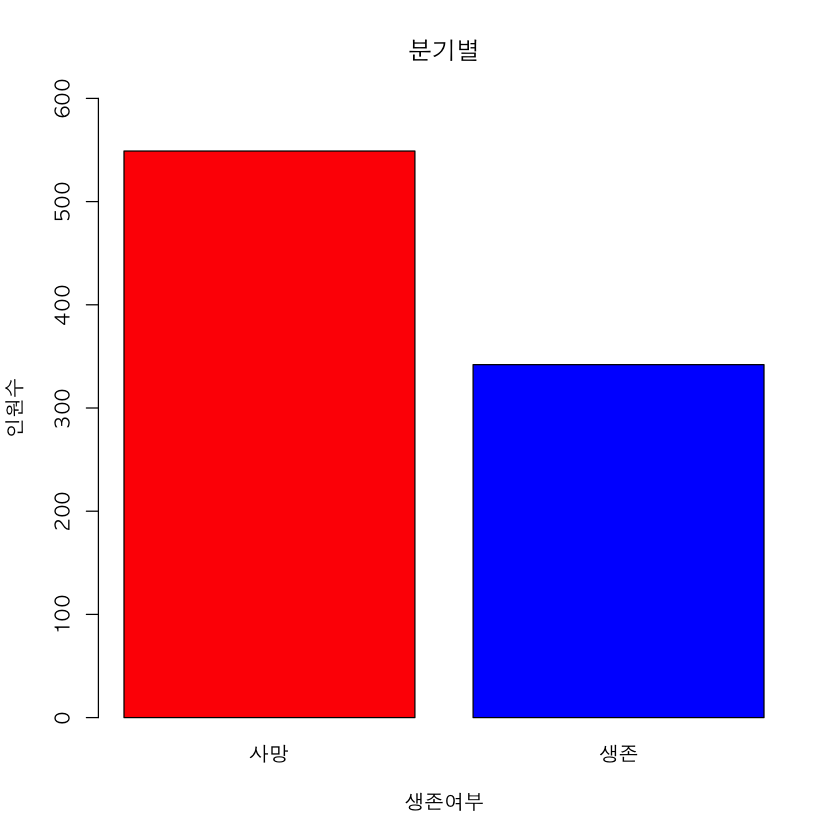

In [10]:
# 막대그래프 생존수와 사망수
# for mac
options(warn = -1)
par(family = "AppleGothic")
x <- c("사망","생존")
y <- c(nrow(subset(train_df,Survived == 0)),nrow(subset(train_df,Survived == 1)))

barplot(y,
        ylim = c(0,600),
        col = c("red","blue"), # r,g,b,alpha(투명도)
        main = "분기별",
        names = c("사망","생존"),
        xlab = "생존여부",
        ylab = "인원수"
       )

### Feature Column 구성을 위해 sex 컬럼 분석

In [15]:
# Sex 컬럼 분류
unique(train_df$Sex)

[1] male   female
Levels: female male

In [17]:
# 여성 인원과 남성 인원 확인
maleCount <- nrow(subset(train_df, Sex=="male"))
femaleCount <- nrow(subset(train_df, Sex=="female"))
print(maleCount)
print(femaleCount)

[1] 577
[1] 314


여성과 남성의 승전 비율이 차이가 나서 Feature로 충분하다.

In [28]:
femaleSurvive <- nrow(subset(train_df, Sex=="female" & Survived == 1))
femaleDeath <- nrow(subset(train_df, Sex=="female" & Survived == 0))

print(paste("여성생존 :",femaleSurvive))
print(paste("여성사망 :",femaleDeath))


[1] "여성생존 : 233"
[1] "여성사망 : 81"


In [27]:
maleSurvive <- nrow(subset(train_df, Sex=="male" & Survived == 1))
maleDeath <- nrow(subset(train_df, Sex=="male" & Survived == 0))
print(paste("남성생존 :",maleSurvive))
print(paste("남성사망 :",maleDeath))


[1] "남성생존 : 109"
[1] "남성사망 : 468"


Sex 컬럼은 Feature Column으로 충분해 보인다.

In [30]:
# 남성의 생존율과 사망율
paste("남성의 생존율 : ",round(maleSurvive / maleCount * 100,2), "%")
paste("남성의 사망율 : ",round(maleDeath / maleCount * 100,2), "%")

[1] "남성의 생존율 :  18.89 %"

[1] "남성의 사망율 :  81.11 %"

### 티켓 등급 분석

In [34]:
# 컬럼의 속성 파악
table(train_df$Pclass)


  1   2   3 
216 184 491 

In [35]:
# 1등 객실의 여성 생존율
femaleSurvive_1st <- nrow(subset(train_df, Sex=="female" & Survived == 1 & Pclass == 1))
femaleSurviveRation_1st <- femaleSurvive_1st / nrow(subset(train_df, Sex=="female" & Pclass == 1)) * 100
paste("1등 객실의 여성 생존율은 ",round(femaleSurviveRation_1st,2),"%")

[1] "1등 객실의 여성 생존율은  96.81 %"

In [40]:
maleData <- c()
femaleData <- c()

for( gender in c("female","male")){
    for(i in 1:3){
         cat(i,"등 객실의 ",ifelse(gender == "female","여성","남성")," 생존율은 ",round(nrow(subset(train_df, Sex==gender & Survived == 1 & Pclass == i)) /
                             nrow(subset(train_df, Sex==gender & Pclass == i)) * 100,2),"%\n")
        if(gender == "female"){
            femaleData[i] = round(nrow(subset(train_df, Sex==gender & Survived == 1 & Pclass == i)) /
                             nrow(subset(train_df, Sex==gender & Pclass == i)) * 100,2)
        }else{
            maleData[i] = round(nrow(subset(train_df, Sex==gender & Survived == 1 & Pclass == i)) /
                             nrow(subset(train_df, Sex==gender & Pclass == i)) * 100,2)
        }
        
    }
    cat("-----------------------------------\n")
}

1 등 객실의  여성  생존율은  96.81 %
2 등 객실의  여성  생존율은  92.11 %
3 등 객실의  여성  생존율은  50 %
-----------------------------------
1 등 객실의  남성  생존율은  36.89 %
2 등 객실의  남성  생존율은  15.74 %
3 등 객실의  남성  생존율은  13.54 %
-----------------------------------


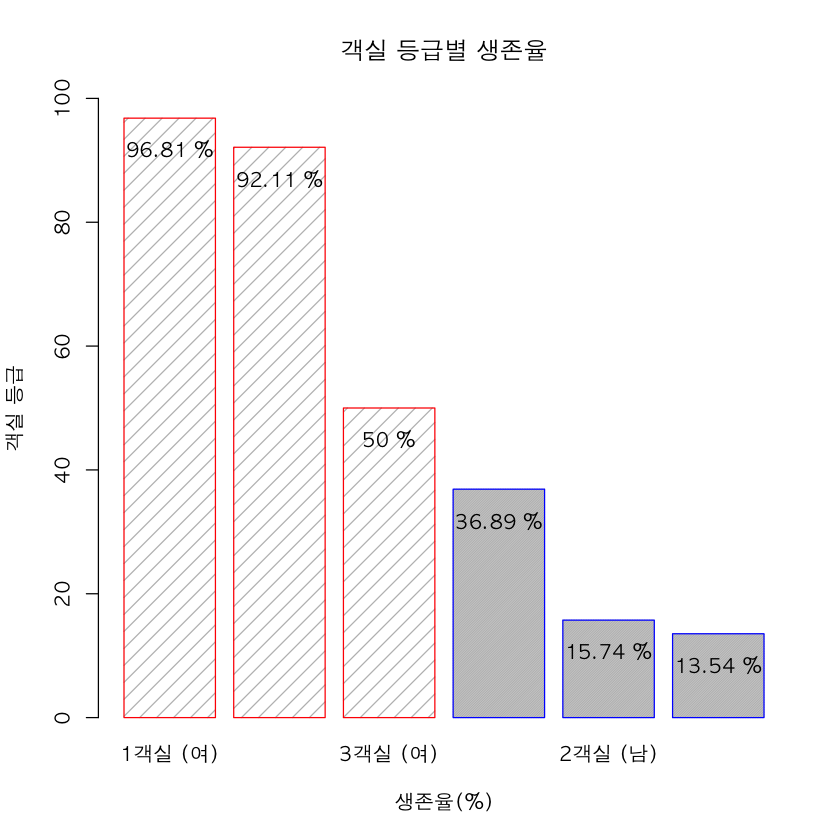

In [41]:
vecData <- c(femaleData,maleData)
# for mac
options(warn = -1)
par(family = "AppleGothic")
barplot(vecData,
        main="객실 등급별 생존율",
        ylab="객실 등급",
        xlab="생존율(%)",
        ylim=c(0,100),
        names = c("1객실 (여)","2객실 (여)","3객실 (여)","1객실 (남)","2객실 (남)","3객실 (남)"),
        border = c(rep("red",3),rep("blue",3)),
        density = c(rep(10,3),rep(100,3)),
        
        
        
       )
for( i in 1:6){
    text(0.7 + 1.2*(i-1),vecData[i]-5,paste(vecData[i],"%"))
}


### Embarked(항구) 와의 연관성 확인

In [42]:
# 항구 이름 확인
unique(train_df$Embarked)

[1] S C Q  
Levels:  C Q S

In [44]:
# 평균 운임
mean(train_df$Fare)
# 운임을 제일 많이 지불한 사람
max(train_df$Fare)

[1] 32.20421

[1] 512.3292

In [45]:
subset(train_df, Fare == max(train_df$Fare))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
259,259,1,1,"Ward, Miss. Anna",female,35,0,0,PC 17755,512.3292,,C
680,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36,0,1,PC 17755,512.3292,B51 B53 B55,C
738,738,1,1,"Lesurer, Mr. Gustave J",male,35,0,0,PC 17755,512.3292,B101,C


나이도 비슷하고 탑승한 항구가 같다

In [47]:
# 항구별 탑승인원을 구하여 가장 많은 탑승인원의 항구로 결정

# S항구의 탑승인원
sum(train_df$Embarked == 'S')

# C항구의 탑승인원
sum(train_df$Embarked == 'C')

# Q항구의 탑승인원
sum(train_df$Embarked == 'Q')

[1] 644

[1] 168

[1] 77

In [52]:
train_df[train_df$Embarked == "",]

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [51]:
# 빈칸 항구를 가장 많이 탑승한 S 항구로 변경
train_df[train_df$Embarked == "",]$Embarked <- 'S'

In [53]:
sum(train_df$Embarked == "S")

[1] 646

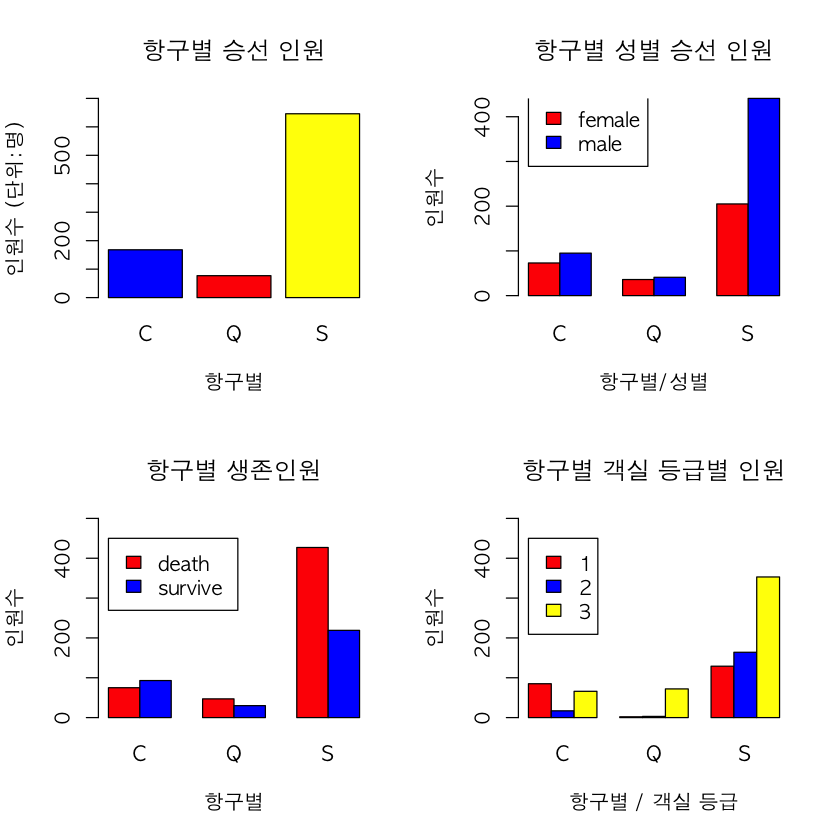

In [57]:
train_df$Embarked <- factor(train_df$Embarked)
temp <- split.screen(c(2,2))
# for mac
options(warn = -1)
screen(1)
par(family = "AppleGothic")
# 항구별 탑승인원
barplot(table(train_df$Embarked),
        main ="항구별 승선 인원",
        xlab ="항구별",
        ylab="인원수 (단위:명)",
        col =c("blue","red","yellow"),
        ylim = c(0,700)
       )
screen(2)
# 항구별 성별 승선 인원
barplot(table(train_df$Sex,train_df$Embarked),
        beside = T,
        col = c("red","blue"),
        main = "항구별 성별 승선 인원",
        ylab= "인원수",
        xlab="항구별/성별"

       )
legend(1,450,
       c('female', 'male'),
       fill = c("red", "blue"),
      )
screen(3)
# 항구별 생존인원
barplot(table(train_df$Survived,train_df$Embarked),
        beside = T,
        col = c("red","blue"),
        main = "항구별 생존인원",
        ylab= "인원수",
        xlab="항구별",
        ylim=c(0,500)

       )
legend(1,450,
       c('death', 'survive'),
       fill = c("red", "blue"),
      )
screen(4)
# 항구별 객실 등급별 인원
barplot(table(train_df$Pclass,train_df$Embarked),
        beside = T,
        col = c("red","blue","yellow"),
        main = "항구별 객실 등급별 인원",
        ylab= "인원수",
        xlab="항구별 / 객실 등급",
        ylim=c(0,500)

       )
legend(1,450,
       c('1', '2','3'),
       fill = c("red", "blue","yellow"),
      )

절반 이상의 승객이 S항구에서 배를 탔으며 남성이 압도적으로 많고 남성 사망률이 높았기 때문에 S 항구 사망율이 높게 나왔다.   
S 항구에서 탑승한 승객들의 대부분은 3등급 객실을 이용했고, C항구에서 탑승한 승객들은 1등급 객실 비중이 높은걸 보니   
C 항구가 있는 동네는 부자동네인것 같다.

In [60]:
# 상관계수
cor(train_df$Survived, as.numeric(train_df$Sex))
cor(train_df$Survived, train_df$Pclass)
cor(train_df$Survived, as.numeric(train_df$Embarked))

[1] -0.5433514

[1] -0.338481

[1] -0.1676753

In [61]:
str(train_df)

'data.frame':	891 obs. of  12 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : Factor w/ 891 levels "Abbing, Mr. Anthony",..: 109 191 354 273 16 555 516 625 413 577 ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : Factor w/ 681 levels "110152","110413",..: 524 597 670 50 473 276 86 396 345 133 ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : Factor w/ 148 levels "","A10","A14",..: 1 83 1 57 1 1 131 1 1 1 ...
 $ Embarked   : Factor w/ 3 levels "C","Q","S": 3 1 3 3 3 2 3 3 3 1 ...


In [65]:
# 복사
train_df_T <- train_df

In [66]:
# 성별을 숫자로 전환
train_df_T$SexCode[train_df_T$Sex == 'male'] <- 0
train_df_T$SexCode[train_df_T$Sex == 'female'] <- 1
head(train_df_T)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,SexCode
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,,S,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C,1
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,,S,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,1
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,,S,0
6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,,Q,0


In [67]:
# 예측을 위한 컬럼 확인
target_col <- c("Survived","SexCode","Pclass","Embarked")
head(train_df_T[,target_col])

Survived,SexCode,Pclass,Embarked
0,0,3,S
1,1,1,C
1,1,3,S
1,1,1,S
0,0,3,S
0,0,3,Q


In [68]:
# Sex 컬럼 삭제
train_df_T <- subset(train_df_T, select = -Sex)
head(train_df_T)

PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,SexCode
1,0,3,"Braund, Mr. Owen Harris",22,1,0,A/5 21171,7.2500,,S,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",38,1,0,PC 17599,71.2833,C85,C,1
3,1,3,"Heikkinen, Miss. Laina",26,0,0,STON/O2. 3101282,7.9250,,S,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35,1,0,113803,53.1000,C123,S,1
5,0,3,"Allen, Mr. William Henry",35,0,0,373450,8.0500,,S,0
6,0,3,"Moran, Mr. James",NA,0,0,330877,8.4583,,Q,0


In [72]:
# 예측을 위한 컬럼 확인
target_col <- c("Survived","SexCode","Pclass","Embarked")
head(train_df_T[,target_col])

Survived,SexCode,Pclass,Embarked
0,0,3,S
1,1,1,C
1,1,3,S
1,1,1,S
0,0,3,S
0,0,3,Q


Embarked 도 숫자로 변환

### One-Hot Encoding 방법
C = [1,0,0]   
S = [0,1,0]   
Q = [0,0,1]   
   
C = [T,F,F]   
S = [F,T,F]   
Q = [F,F,T]   


In [73]:
train_df_T$Embarked_C = train_df_T$Embarked == "C"
train_df_T$Embarked_S = train_df_T$Embarked == "S"
train_df_T$Embarked_Q = train_df_T$Embarked == "Q"

In [74]:
head(train_df_T[,c("Embarked","Embarked_C","Embarked_S","Embarked_Q")])

Embarked,Embarked_C,Embarked_S,Embarked_Q
S,FALSE,TRUE,FALSE
C,TRUE,FALSE,FALSE
S,FALSE,TRUE,FALSE
S,FALSE,TRUE,FALSE
S,FALSE,TRUE,FALSE
Q,FALSE,FALSE,TRUE


In [75]:
# Sampling
set.seed(1234)
samp <- createDataPartition(train_df_T$Survived, p=0.7,list=F)

In [76]:
# 학습용
data.train <- train_df_T[samp,]
# 검증용
test.train <- train_df_T[-samp,]

In [77]:
## Target column 으로만 구성
# train 구성
train_data <- data.train[,target_col]
# test 구성
test_data <- test.train[,target_col]

In [78]:
# 문제 및 정답 만들기
x <- subset(test_data, select = -Survived)
y <- test_data$Survived

In [80]:
train_data$Survived <- as.factor(train_data$Survived)
test_data$Survived <- as.factor(test_data$Survived)

In [82]:
# 학습시키기

# 인공신경망
train.nnet <- nnet(Survived ~ ., data=train_data, size = 3)

# 의사결정 나무
train.ctree <- ctree(Survived ~ ., data=train_data)

# 랜덤포레스트
train.randomForest <- randomForest(Survived ~ ., data=train_data, ntree = 100)

#SVM
train.svm <- svm(Survived ~ ., data=train_data)

# 로지스틱 회귀분석
train.multinom <- multinom(Survived ~ ., data=train_data)

# weights:  19
initial  value 422.535794 
iter  10 value 286.807260
iter  20 value 281.990842
iter  30 value 281.744911
iter  40 value 281.591349
iter  50 value 281.471477
iter  60 value 281.319507
iter  70 value 281.213821
iter  80 value 281.179378
iter  90 value 281.177293
iter 100 value 281.150668
final  value 281.150668 
stopped after 100 iterations
# weights:  6 (5 variable)
initial  value 432.523841 
iter  10 value 297.884311
final  value 297.883811 
converged


In [83]:
# 검증하기

# 인공신경망
pred.nnet <- predict(train.nnet, x, type="class")

# 의사결정나무
pred.ctree <- predict(train.ctree, x)

# RandomForest
pred.randForest <- predict(train.randomForest, x)

#svm
pred.svm <- predict(train.svm, x)

# 로지스틱 회귀분석
pred.mutinom <- predict(train.multinom, x)

In [89]:
# 인공신경망
mean(pred.nnet == y)
table(pred.nnet,y)

[1] 0.8277154

         y
pred.nnet   0   1
        0 162  39
        1   7  59

In [90]:
# 의사결정나무
mean(pred.ctree == y)
table(pred.ctree,y)

[1] 0.8277154

          y
pred.ctree   0   1
         0 162  39
         1   7  59

In [91]:
# RandomForest
mean(pred.randForest == y)
table(pred.randForest,y)


[1] 0.8277154

               y
pred.randForest   0   1
              0 162  39
              1   7  59

In [92]:
#svm
mean(pred.svm == y)
table(pred.svm,y)


[1] 0.8277154

        y
pred.svm   0   1
       0 162  39
       1   7  59

In [94]:
# 로지스틱 회귀분석
mean(pred.mutinom == y)
table(pred.mutinom,y)

[1] 0.7977528

            y
pred.mutinom   0   1
           0 137  22
           1  32  76